# Backtesting with [**vectorbt**](https://github.com/polakowo/vectorbt)
* Data Acquisition (**yfinance**)
* Statistical and Technical Analysis (**pandas_ta**)
* Backtesting Analysis and Results (**vectorbt**)

### Initializations

In [1]:
import asyncio
import itertools
from datetime import datetime

from IPython import display

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt

import plotly.graph_objects as go

print("Package Versions:")
print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"vectorbt v{vbt.__version__}")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")

%matplotlib inline

Package Versions:
Numpy v1.20.3
Pandas v1.3.0
vectorbt v0.23.1

Pandas TA v0.3.48b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



# **vectorbt** Theme and Portfolio Settings

In [2]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 100_000
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False
vbt.settings.portfolio["signal_direction"] = "both"

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,100000
size,inf
size_type,amount
fees,0.0025
fixed_fees,0.0
slippage,0.0025
reject_prob,0.0
min_size,0.0


## Helper Methods

In [3]:
def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
    header = pd.Series({
        "Run Time": ta.get_time(full=False, to_string=True),
        "Mode": "LIVE" if mode else "TEST",
        "Strategy": strategy,
        "Direction": vbt.settings.portfolio["signal_direction"],
        "Symbol": ticker.upper(),
        "Fees [%]": 100 * vbt.settings.portfolio["fees"],
        "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
        "Accumulate": vbt.settings.portfolio["accumulate"],
    })
    rstats = pf.returns_stats().dropna(axis=0).T
    stats = pf.stats().dropna(axis=0).T
    joint = pd.concat([header, stats, rstats])
    return joint[~joint.index.duplicated(keep="first")]

def earliest_common_index(d: dict):
    """Returns index of the earliest common index of all DataFrames in the dict"""
    min_date = None
    for df in d.values():
        if min_date is None:
            min_date = df.index[0]
        elif min_date < df.index[0]:
            min_date = df.index[0]
    return min_date

def dl(tickers: list, same_start: bool = False, **kwargs):
    if isinstance(tickers, str):
        tickers = [tickers]
    
    if not isinstance(tickers, list) or len(tickers) == 0:
        print("Must be a non-empty list of tickers or symbols")
        return

    if "limit" in kwargs and kwargs["limit"] and len(tickers) > kwargs["limit"]:
        from itertools import islice            
        tickers = list(islice(tickers, kwargs["limit"]))
        print(f"[!] Too many assets to compare. Using the first {kwargs['limit']}: {', '.join(tickers)}")

    print(f"[i] Downloading: {', '.join(tickers)}")

    received = {}
    if len(tickers):
        _df = pd.DataFrame()
        for ticker in tickers:
            received[ticker] = _df.ta.ticker(ticker, **kwargs)
            print(f"[+] {ta.get_time(full=False, to_string=True)}")
    
    if same_start and len(tickers) > 1:
        earliestci = earliest_common_index(received)
        print(f"[i] Earliest Common Date: {earliestci}")
        result = {ticker:df[df.index > earliestci].copy() for ticker,df in received.items()}
    else:
        result = received
    print(f"[*] Download Complete\n")
    return result

def dtmask(df: pd.DataFrame, start: datetime, end: datetime):
    return df.loc[(df.index >= start) & (df.index <= end), :].copy()

def show_data(d: dict):
    [print(f"{t}[{df.index[0]} - {df.index[-1]}]: {df.shape} {df.ta.time_range:.2f} years") for t,df in d.items()]
    
def trade_table(pf: vbt.portfolio.base.Portfolio, k: int = 1, total_fees: bool = False):
    if not isinstance(pf, vbt.portfolio.base.Portfolio): return
    k = int(k) if isinstance(k, int) and k > 0 else 1

    df = pf.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]]
    if total_fees:
        df["total_fees"] = df["entry_fees"] + df["exit_fees"]

    print(f"\nLast {k} of {df.shape[0]} Trades\n{df.tail(k)}\n")

# Data Acquisition

#### Specify Symbols for Benchmarks and Assets

In [4]:
benchmark_tickers = ["SPY", "QQQ"]
asset_tickers = ["AAPL", "TSLA", "TWTR"]
all_tickers = benchmark_tickers + asset_tickers

print("Tickers by index #")
print("="*100)
print(f"Benchmarks: {', '.join([f'{k}: {v}' for k,v in enumerate(benchmark_tickers)])}")
print(f"    Assets: {', '.join([f'{k}: {v}' for k,v in enumerate(asset_tickers)])}")
print(f"       All: {', '.join([f'{k}: {v}' for k,v in enumerate(all_tickers)])}")

Tickers by index #
Benchmarks: 0: SPY, 1: QQQ
    Assets: 0: AAPL, 1: TSLA, 2: TWTR
       All: 0: SPY, 1: QQQ, 2: AAPL, 3: TSLA, 4: TWTR


In [5]:
benchmark = benchmark_tickers[0] # Change index for different benchmark
asset = asset_tickers[2] # Change index for different symbol
print(f"Selected Benchmark | Asset: {benchmark} | {asset}")

Selected Benchmark | Asset: SPY | TWTR


In [6]:
benchmarks = dl(benchmark_tickers, timed=True)

[i] Downloading: SPY, QQQ
[+] yf | SPY(7324, 7): 3052.9428 ms (3.0529 s)
[+] Monday February 28, 2022, NYSE: 6:52:24
[+] yf | QQQ(5782, 7): 3106.3748 ms (3.1064 s)
[+] Monday February 28, 2022, NYSE: 6:52:27
[*] Download Complete



In [7]:
assets = dl(asset_tickers, timed=True)

[i] Downloading: AAPL, TSLA, TWTR
[+] yf | AAPL(10391, 7): 2772.3595 ms (2.7724 s)
[+] Monday February 28, 2022, NYSE: 6:52:30
[+] yf | TSLA(2938, 7): 2678.0592 ms (2.6781 s)
[+] Monday February 28, 2022, NYSE: 6:52:32
[+] yf | TWTR(2091, 7): 2632.2783 ms (2.6323 s)
[+] Monday February 28, 2022, NYSE: 6:52:35
[*] Download Complete



### Define Testing Dates and Ranges

In [8]:
start_date = datetime(2005, 1, 1) # Adjust as needed
end_date = datetime(2010, 1, 1)   # Adjust as needed

### Select and Benchmark and Asset to Backtest

In [9]:
print("Available Data:")
print("="*100)
print(f"Benchmarks: {', '.join(benchmarks.keys())}")
print(f"Assets: {', '.join(assets.keys())}")

Available Data:
Benchmarks: SPY, QQQ
Assets: AAPL, TSLA, TWTR


In [10]:
benchmark_name = "SPY" # Select a Benchmark
asset_name = "AAPL" # Select an Asset

benchmarkdf = benchmarks[benchmark_name]
assetdf     = assets[asset_name]

# Set True if you want to constrain Data between start_date & end_date
common_range = True
if common_range:
    crs = f" from {start_date} to {end_date}"
    benchmarkdf = dtmask(benchmarkdf, start_date, end_date)
    assetdf = dtmask(assetdf, start_date, end_date)

# Update DataFrame names
benchmarkdf.name = benchmark_name
assetdf.name = asset_name
print(f"Analysis of: {benchmarkdf.name} and {assetdf.name}{crs if common_range else ''}")

Analysis of: SPY and AAPL from 2005-01-01 00:00:00 to 2010-01-01 00:00:00


#### Sanity Check

In [11]:
benchmarkdf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,87.175203,87.318634,85.984758,86.271614,55748000,0.0,0
2005-01-04,86.386354,86.443727,84.937739,85.217422,69167600,0.0,0
2005-01-05,85.152863,85.518605,84.622183,84.629356,65667300,0.0,0
2005-01-06,84.937742,85.446909,84.808657,85.059654,47814700,0.0,0
2005-01-07,85.317788,85.504245,84.715390,84.937706,55847700,0.0,0
...,...,...,...,...,...,...,...
2009-12-24,88.985001,89.310195,88.834298,89.215019,39677500,0.0,0
2009-12-28,89.548142,89.619524,89.088106,89.405373,87508500,0.0,0
2009-12-29,89.635408,89.651268,89.270553,89.278481,80572500,0.0,0


In [12]:
assetdf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,0.990526,0.995572,0.957192,0.967743,691992000,0.0,0.0
2005-01-04,0.975388,1.001076,0.962849,0.977682,1096810400,0.0,0.0
2005-01-05,0.985632,0.997713,0.979364,0.986245,680433600,0.0,0.0
2005-01-06,0.988843,0.992513,0.968354,0.987009,705555200,0.0,0.0
2005-01-07,0.993889,1.064685,0.990067,1.058874,2227450400,0.0,0.0
...,...,...,...,...,...,...,...
2009-12-24,6.224807,6.402178,6.218690,6.392697,500889200,0.0,0.0
2009-12-28,6.474657,6.542852,6.410130,6.471292,644565600,0.0,0.0
2009-12-29,6.502485,6.505238,6.383218,6.394533,445205600,0.0,0.0


## Creating Trading Signals for **vectorbt**
**vectorbt** can create a Backtest using ```vbt.Portfolio.from_signals(*args, **kwargs)``` based on trends that you create with **Pandas TA**.

### Trend Creation
A **Trend** is the result of some calculation or condition of one or more indicators. For simplicity, a _Trend_ is either ```True``` or ```1``` and _No Trend_ is ```False``` or ```0```. Using the **Hello World** of Trends, the **Golden/Death Cross**, it's Trend is _Long_ when ```long = ma(close, 50) > ma(close, 200) ``` and _Short_ when ```short = ma(close, 50) < ma(close, 200) ```. 

In [13]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame, mamode: str = "sma", fast: int = 50, slow: int = 200):
    return ta.ma(mamode, df.Close, length=fast) > ta.ma(mamode, df.Close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.Close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.Close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

### Display Trends

In [14]:
trend_kwargs = {"mamode": "sma", "fast": 50, "slow": 200}

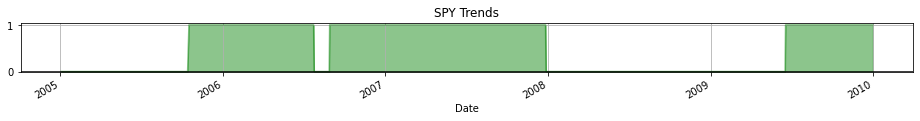

In [15]:
benchmark_trends = trends(benchmarkdf, **trend_kwargs)
benchmark_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{benchmarkdf.name} Trends", grid=True).axhline(0, color="black")

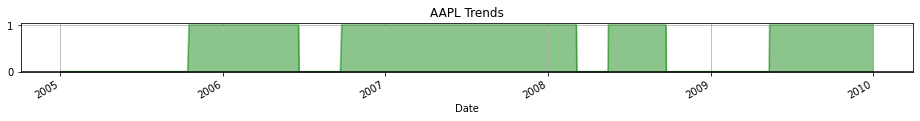

In [16]:
asset_trends = trends(assetdf, **trend_kwargs)
asset_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{assetdf.name} Trends", grid=True).axhline(0, color="black")

### **Trend Signals** 
Given a _Trend_, **Trend Signals** returns the _Trend_, _Trades_, _Entries_ and _Exits_ as boolean integers. When ```asbool=True```, it returns _Trends_, _Entries_ and _Exits_ as boolean values which is helpful when combined with the [**vectorbt**](https://github.com/polakowo/vectorbt) backtesting package.

In [17]:
# trade_offset = 0 for Live Signals (close is last price)
# trade_offset = 1 for Backtesting
LIVE = 0

benchmark_signals = assetdf.ta.tsignals(benchmark_trends, asbool=True, trade_offset=LIVE, append=True)
benchmark_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Date,,,,
2009-12-24,True,0,False,False
2009-12-28,True,0,False,False
2009-12-29,True,0,False,False
2009-12-30,True,0,False,False
2009-12-31,True,0,False,False


In [18]:
asset_signals = assetdf.ta.tsignals(asset_trends, asbool=True, trade_offset=LIVE, append=True)
asset_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Date,,,,
2009-12-24,True,0,False,False
2009-12-28,True,0,False,False
2009-12-29,True,0,False,False
2009-12-30,True,0,False,False
2009-12-31,True,0,False,False


## Creating **vectorbt** Portfolios
* [**vectorbt** Portfolio Options](https://polakowo.io/vectorbt/docs/portfolio/base.html)

### Buy 'N Hold Portfolios with their Single Trade and Performance Statistics

In [19]:
# Benchmark Buy and Hold (BnH) Strategy
benchmarkpf_bnh = vbt.Portfolio.from_holding(benchmarkdf.Close)
print(trade_table(benchmarkpf_bnh))
combine_stats(benchmarkpf_bnh, benchmarkdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction         size  entry_price  exit_price    return  \
0       0          0  1153.355827    86.487293   88.390152  0.019502   

           pnl  entry_fees  exit_fees  
0  1945.296804  249.376559        0.0  

None


Run Time                     Monday February 28, 2022, NYSE: 6:52:38
Mode                                                            TEST
Strategy                                                Buy and Hold
Direction                                                       both
Symbol                                                           SPY
Fees [%]                                                        0.25
Slippage [%]                                                    0.25
Accumulate                                                     False
Start                                            2005-01-03 00:00:00
End                                              2009-12-31 00:00:00
Period                                            1259 days 00:00:00
Start Value                                                 100000.0
End Value                                              101945.296804
Total Return [%]                                            1.945297
Benchmark Return [%]              

In [20]:
# Asset Buy and Hold (BnH) Strategy
assetpf_bnh = vbt.Portfolio.from_holding(assetdf.Close)
print(trade_table(assetpf_bnh))
combine_stats(assetpf_bnh, assetdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction           size  entry_price  exit_price    return  \
0       0          0  102818.467805     0.970163    6.444379  5.640077   

             pnl  entry_fees  exit_fees  
0  562601.208633  249.376559        0.0  

None


Run Time                     Monday February 28, 2022, NYSE: 6:52:40
Mode                                                            TEST
Strategy                                                Buy and Hold
Direction                                                       both
Symbol                                                          AAPL
Fees [%]                                                        0.25
Slippage [%]                                                    0.25
Accumulate                                                     False
Start                                            2005-01-03 00:00:00
End                                              2009-12-31 00:00:00
Period                                            1259 days 00:00:00
Start Value                                                 100000.0
End Value                                              662601.208633
Total Return [%]                                          562.601209
Benchmark Return [%]              

### Signal Portfolios with their Last 'k' Trades and Performance Statistics

In [21]:
# Benchmark Portfolio from Trade Signals
benchmarkpf_signals = vbt.Portfolio.from_signals(
    benchmarkdf.Close,
    entries=benchmark_signals.TS_Entries,
    exits=benchmark_signals.TS_Exits,
)
trade_table(benchmarkpf_signals, k=5)
combine_stats(benchmarkpf_signals, benchmarkdf.name, "Long Strategy", LIVE)


Last 5 of 5 Trades
   status  direction         size  entry_price  exit_price    return  \
0       1          0  1150.758533    86.682497   92.979310  0.067461   
1       1          1  1145.019089    92.979310   96.337426 -0.041207   
2       1          0  1059.681526    96.337426  111.226836  0.149168   
3       1          1  1054.396331   111.226836   72.182241  0.346913   
4       0          0  2186.974521    72.182241   88.390152  0.222042   

            pnl  entry_fees   exit_fees  
0   6729.243061  249.376559  267.491837  
1  -4387.034807  266.157713  275.770480  
2  15228.152450  255.217477  294.662558  
3  40685.013050  293.192919  190.271725  
4  35051.636542  394.651805    0.000000  



Run Time                      Monday February 28, 2022, NYSE: 6:52:43
Mode                                                             TEST
Strategy                                                Long Strategy
Direction                                                        both
Symbol                                                            SPY
Fees [%]                                                         0.25
Slippage [%]                                                     0.25
Accumulate                                                      False
Start                                             2005-01-03 00:00:00
End                                               2009-12-31 00:00:00
Period                                             1259 days 00:00:00
Start Value                                                  100000.0
End Value                                               193307.010295
Total Return [%]                                             93.30701
Benchmark Return [%]

In [22]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    assetdf.Close,
    entries=asset_signals.TS_Entries,
    exits=asset_signals.TS_Exits,
)
trade_table(assetpf_signals, k=5)
combine_stats(assetpf_signals, assetdf.name, "Long Strategy", LIVE)


Last 5 of 7 Trades
   status  direction          size  entry_price  exit_price    return  \
2       1          0  31274.957324     2.322318    3.688943  0.582004   
3       1          1  31118.972499     3.688943    5.751992 -0.565650   
4       1          0   8696.749673     5.751992    3.869225 -0.331506   
5       1          1   8653.374363     3.869225    3.663286  0.048358   
6       0          0   9580.725397     3.663286    6.444379  0.756680   

            pnl  entry_fees   exit_fees  
2  42271.144392  181.575988  288.428861  
3 -64934.425122  286.990314  447.490175  
4 -16583.130130  125.059079   84.124212  
5   1619.117766   83.704640   79.249460  
6  26557.150475   87.742340    0.000000  



Run Time                      Monday February 28, 2022, NYSE: 6:52:44
Mode                                                             TEST
Strategy                                                Long Strategy
Direction                                                        both
Symbol                                                           AAPL
Fees [%]                                                         0.25
Slippage [%]                                                     0.25
Accumulate                                                      False
Start                                             2005-01-03 00:00:00
End                                               2009-12-31 00:00:00
Period                                             1259 days 00:00:00
Start Value                                                  100000.0
End Value                                                61741.828711
Total Return [%]                                           -38.258171
Benchmark Return [%]

## Buy and Hold Plots

In [23]:
vbt.settings.set_theme("seaborn")

### Benchmark

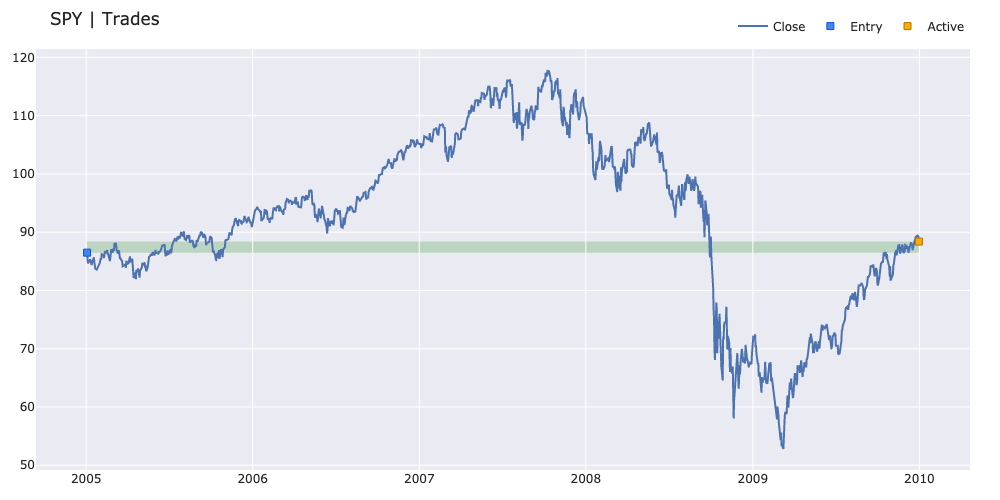

In [24]:
benchmarkpf_bnh.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

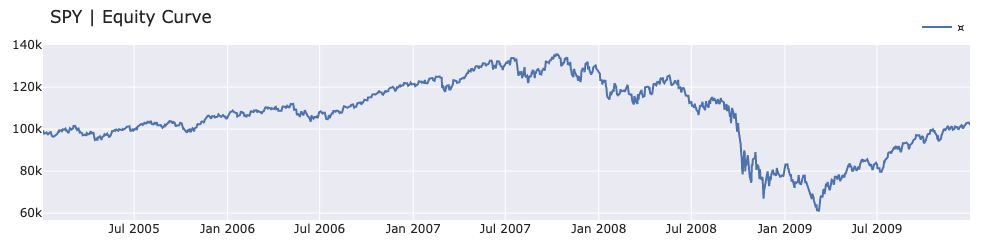

In [25]:
benchmarkpf_bnh.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

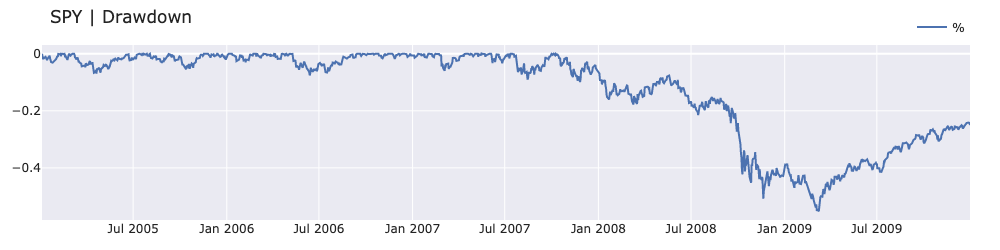

In [26]:
benchmarkpf_bnh.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

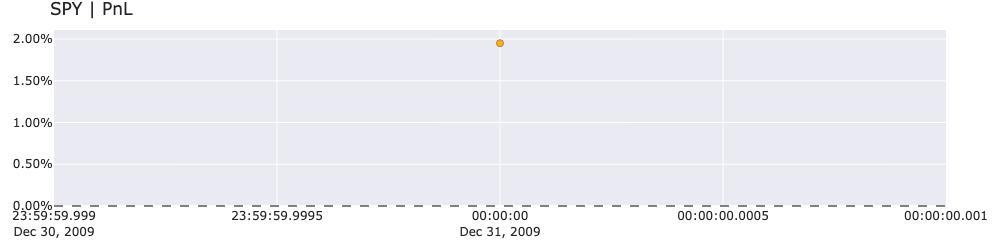

In [27]:
benchmarkpf_bnh.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

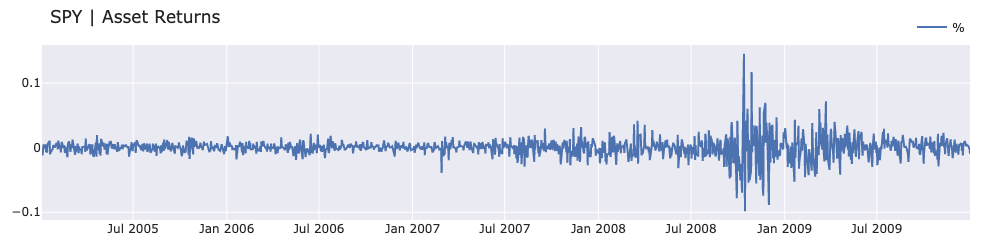

In [28]:
benchmarkpf_bnh.asset_returns().vbt.plot(title=f"{benchmarkdf.name} | Asset Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

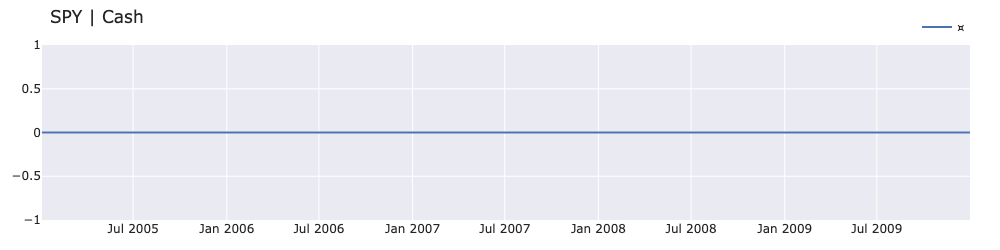

In [29]:
benchmarkpf_bnh.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

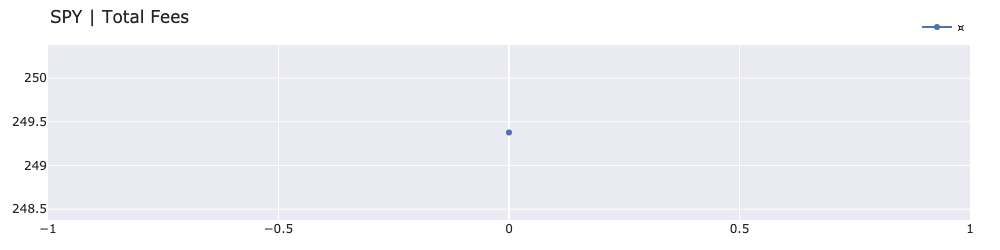

In [30]:
total_assetfees = benchmarkpf_bnh.trades.records_readable["Entry Fees"] + benchmarkpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

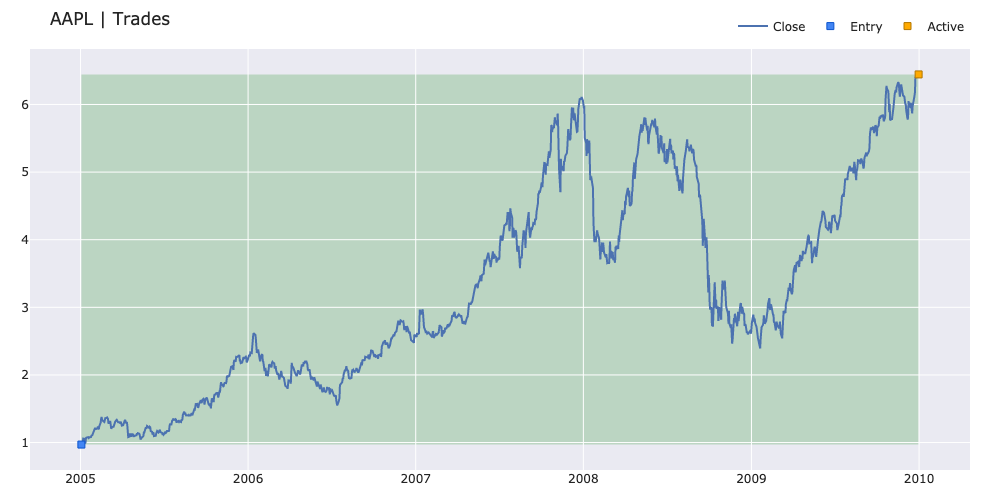

In [31]:
assetpf_bnh.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

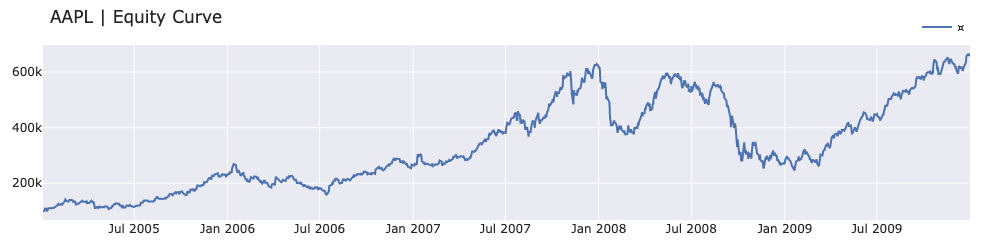

In [32]:
assetpf_bnh.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

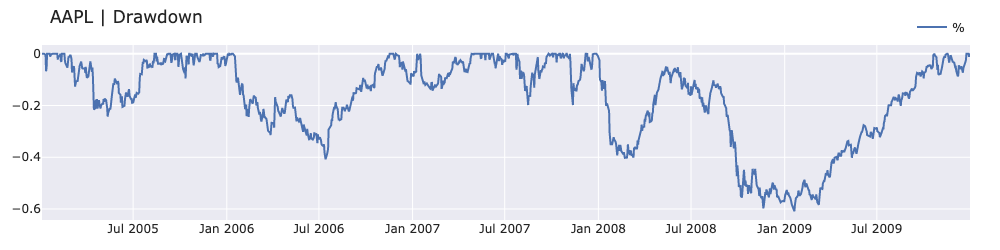

In [33]:
assetpf_bnh.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

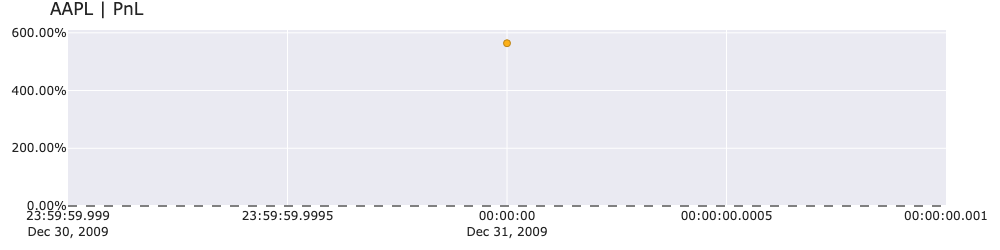

In [34]:
assetpf_bnh.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

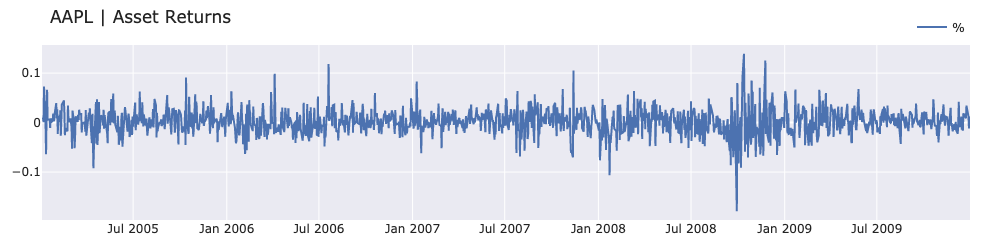

In [35]:
assetpf_bnh.asset_returns().vbt.plot(title=f"{assetdf.name} | Asset Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

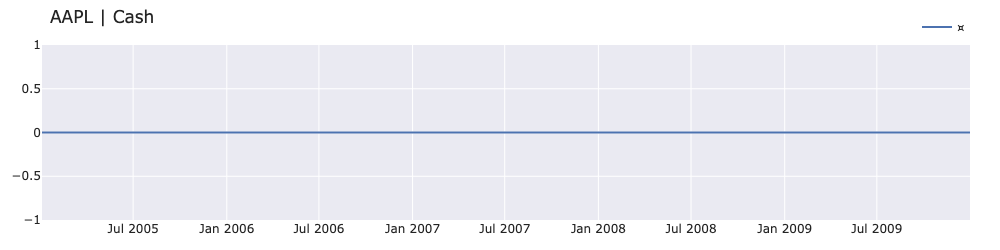

In [36]:
assetpf_bnh.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

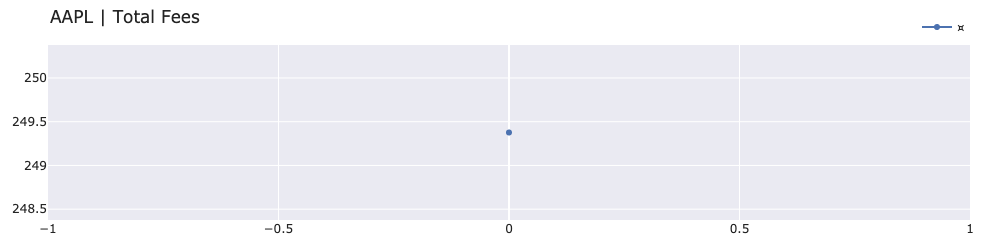

In [37]:
total_assetfees = assetpf_bnh.trades.records_readable["Entry Fees"] + assetpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

## Signal Plots

In [38]:
vbt.settings.set_theme("dark")

### Benchmark

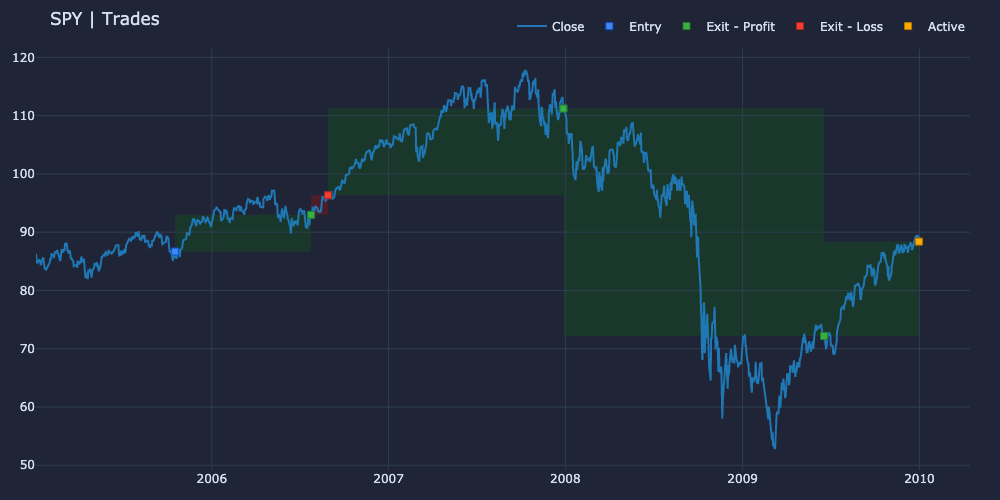

In [39]:
benchmarkpf_signals.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

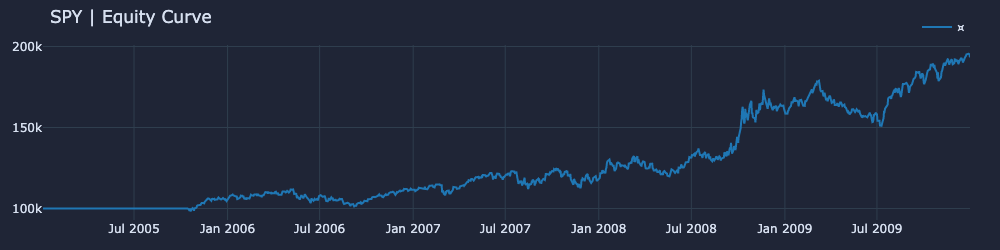

In [40]:
benchmarkpf_signals.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

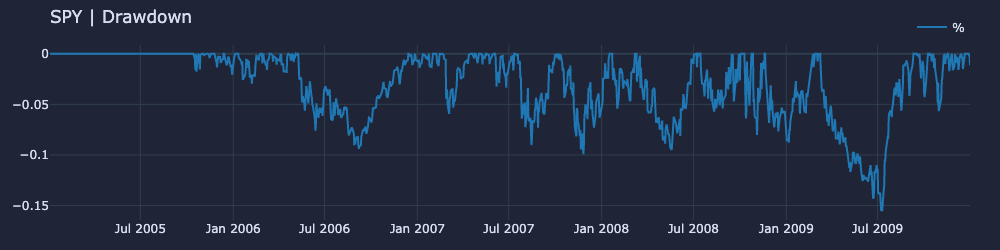

In [41]:
benchmarkpf_signals.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

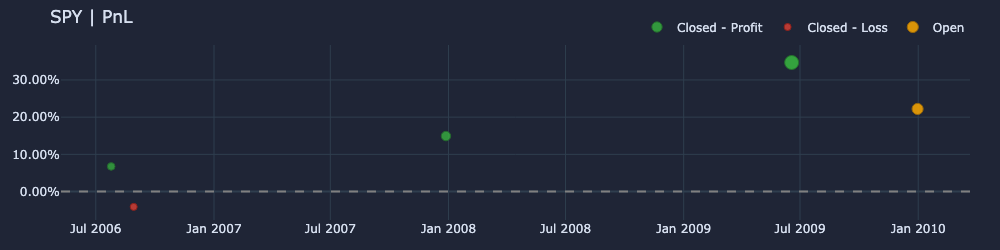

In [42]:
benchmarkpf_signals.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

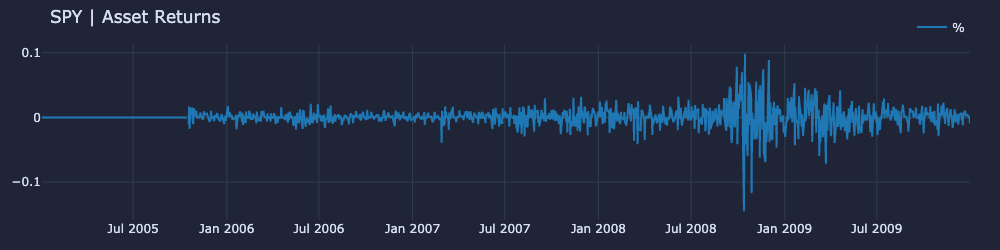

In [43]:
benchmarkpf_signals.asset_returns().vbt.plot(title=f"{benchmarkdf.name} | Asset Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

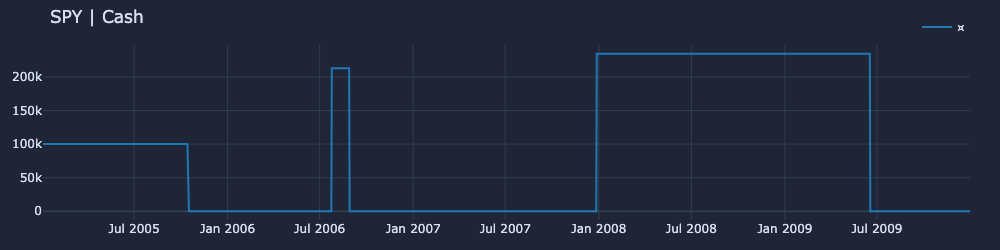

In [44]:
benchmarkpf_signals.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

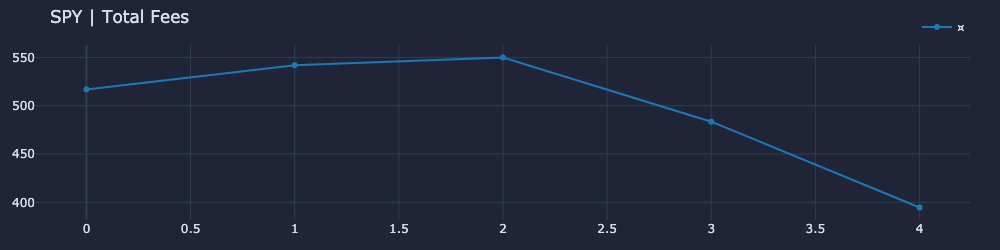

In [45]:
total_assetfees = benchmarkpf_signals.trades.records_readable["Entry Fees"] + benchmarkpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

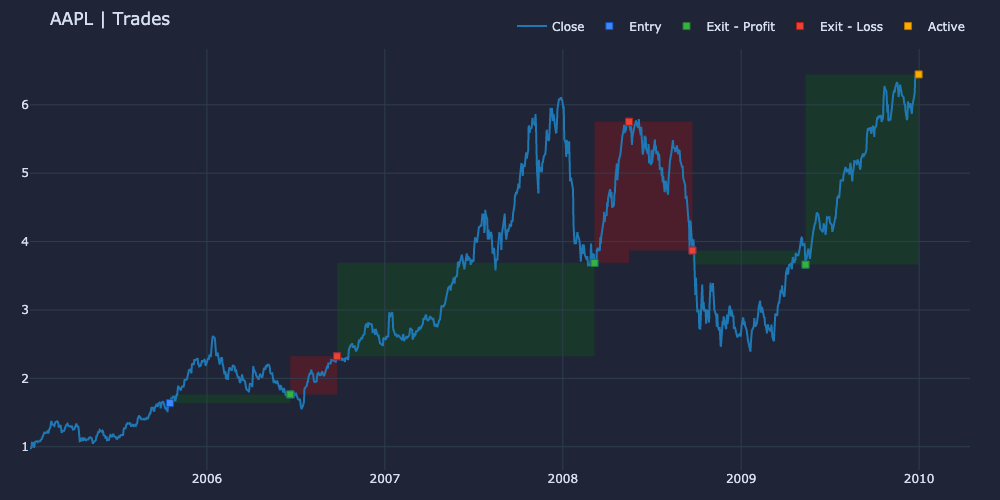

In [46]:
assetpf_signals.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

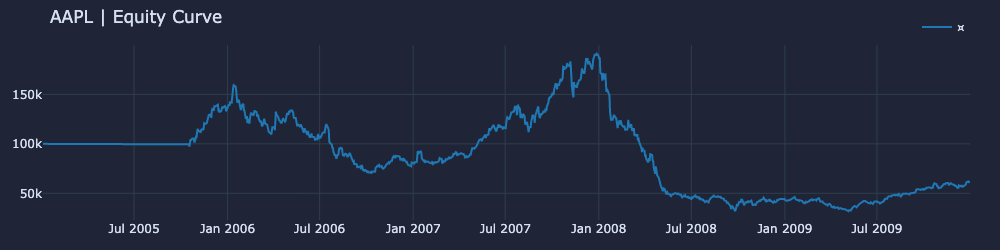

In [47]:
assetpf_signals.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

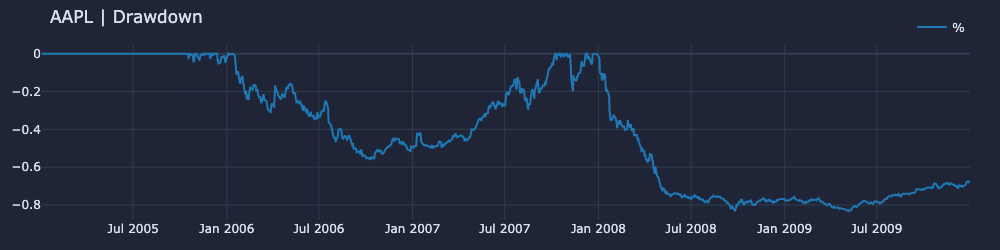

In [48]:
assetpf_signals.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

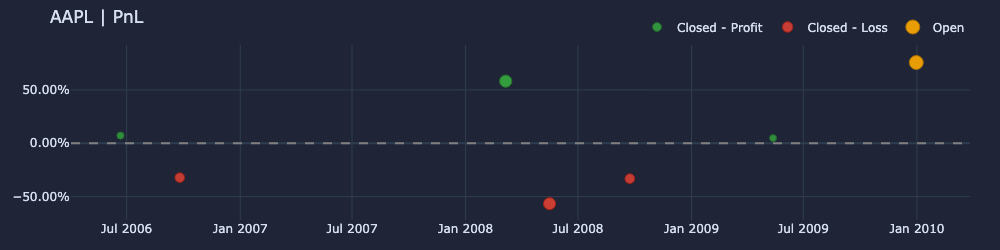

In [49]:
assetpf_signals.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

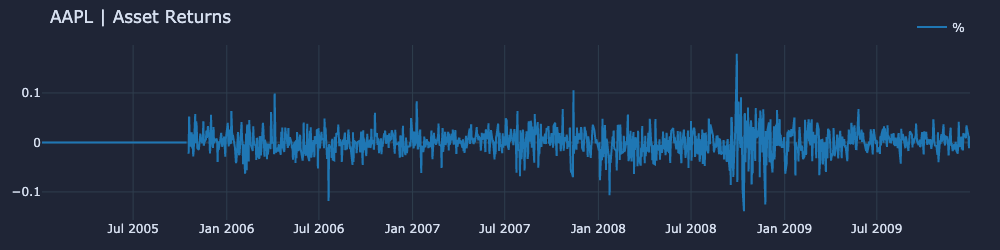

In [50]:
assetpf_signals.asset_returns().vbt.plot(title=f"{assetdf.name} | Asset Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

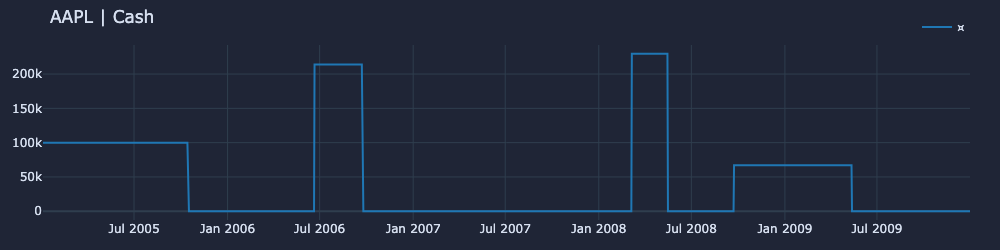

In [51]:
assetpf_signals.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

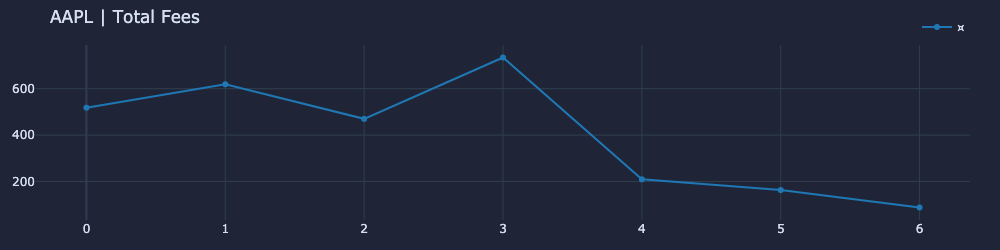

In [52]:
total_assetfees = assetpf_signals.trades.records_readable["Entry Fees"] + assetpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.